## **Creating a steel strip defect classification CNN model via transfer learning**

Note: before running the cell below, make sure that the dataset (zipped file) has been uploaded to Google Drive, Google Drive has been mounted, and the correct path has been specified in the cell below.

In [1]:
# unzip data folder
!unzip -q -o './drive/MyDrive/NEU-data-TrainTest.zip' -d './'

In [2]:
# import packages
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf

In [3]:
# Make results reproducible
import os
import random as rn
from numpy.random import seed
seed(2)
tf.random.set_seed(2)
os.environ['PYTHONHASHSEED'] = str(2)
rn.seed(2)

In [4]:
# create iterators to load images
train_datagen = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

fit_iterator = train_datagen.flow_from_directory(
    directory = './NEU-data-TrainTest/train',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical',
    subset='training')

valid_iterator = train_datagen.flow_from_directory(
    directory = './NEU-data-TrainTest/train',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical',
    subset='validation')

test_iterator = test_datagen.flow_from_directory(
    directory = './NEU-data-TrainTest/test',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle= False)

Found 1386 images belonging to 6 classes.
Found 342 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [5]:
# check class names
class_names = fit_iterator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


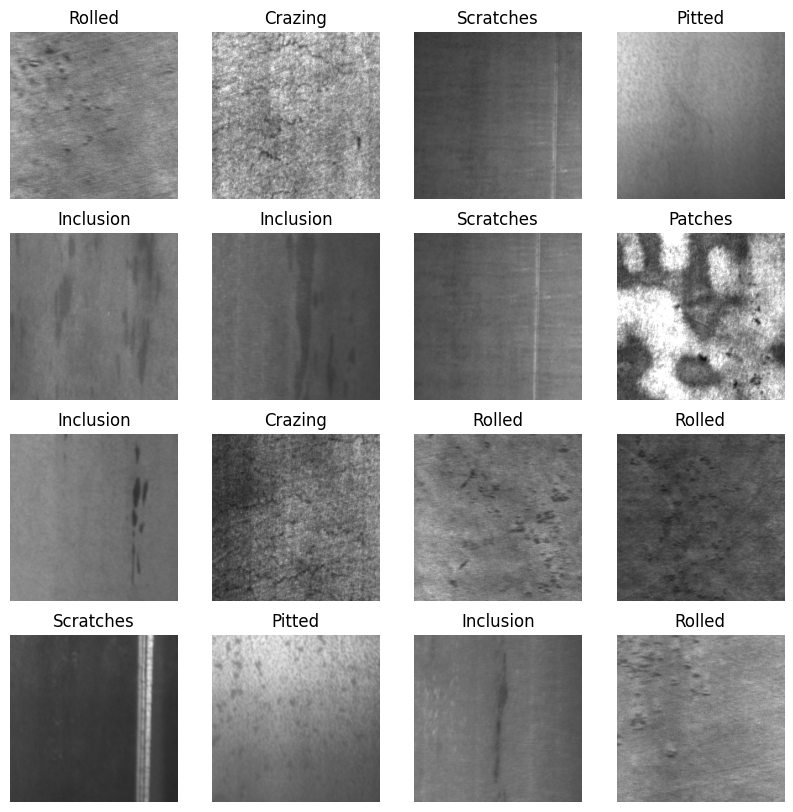

In [6]:
# let's load a few images using the fitting dataset via the iterator
images, labels = fit_iterator.next() # label for each image is in one-hot encoded form

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(16):
    image, label = images[i], labels[i]
    label_name = class_names[np.argmax(label)]
    row, col = i//4, i%4
    axes[row][col].imshow(image)
    axes[row][col].set_title(label_name)
    axes[row][col].axis('off')
plt.show()

In [7]:
# define the CNN model via transfer learning
num_classes = len(class_names)

# specify the pre-trained base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights='imagenet')

# Freeze the convolutional base
base_model.trainable = False

# add a trainable customized classification head to the pre-trained base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 2587462 (9.87 MB)
Trainable params: 329478

In [8]:
# compile and fit
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(fit_iterator, epochs = 9, verbose= 1, validation_data = valid_iterator)

Epoch 1/9
87/87 [==============================] - 17s 105ms/step - loss: 0.3001 - accuracy: 0.8975 - val_loss: 0.0308 - val_accuracy: 0.9942
Epoch 2/9
87/87 [==============================] - 7s 75ms/step - loss: 0.0806 - accuracy: 0.9726 - val_loss: 0.0302 - val_accuracy: 0.9912
Epoch 3/9
87/87 [==============================] - 6s 70ms/step - loss: 0.0361 - accuracy: 0.9913 - val_loss: 0.0250 - val_accuracy: 0.9942
Epoch 4/9
87/87 [==============================] - 6s 72ms/step - loss: 0.0275 - accuracy: 0.9877 - val_loss: 0.0259 - val_accuracy: 0.9912
Epoch 5/9
87/87 [==============================] - 6s 69ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 6/9
87/87 [==============================] - 4s 47ms/step - loss: 0.0187 - accuracy: 0.9949 - val_loss: 0.0181 - val_accuracy: 0.9912
Epoch 7/9
87/87 [==============================] - 6s 58ms/step - loss: 0.0118 - accuracy: 0.9986 - val_loss: 0.0246 - val_accuracy: 0.9912
Epoch 8/9
87/87 [=

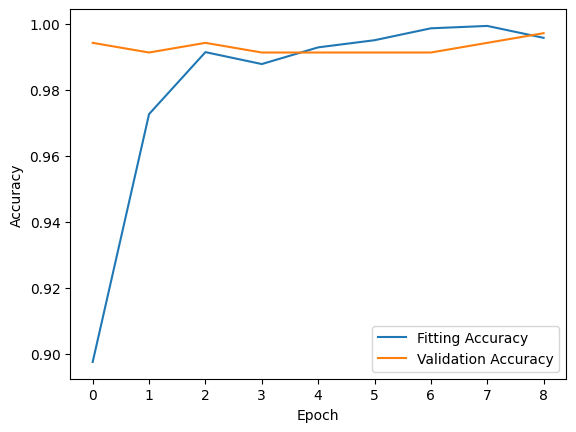

In [9]:
# plot validation curve
plt.figure()
plt.plot(history.history['accuracy'], label='Fitting Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# check performance on test dataset
result = model.evaluate(test_iterator)
print("Test loss, Test accuracy : ", result)

5/5 [==============================] - 3s 778ms/step - loss: 0.0245 - accuracy: 0.9861
Test loss, Test accuracy :  [0.024525072425603867, 0.9861111044883728]


5/5 [==============================] - 2s 368ms/step


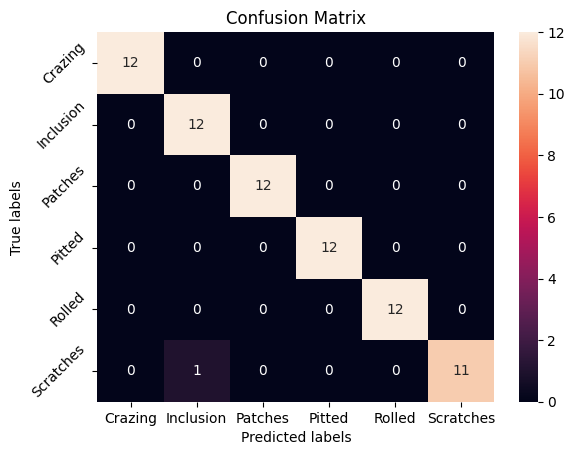

In [11]:
# plot confusion matrix for test dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

probs_preds = model.predict(test_iterator) # each image is assigned 6 probabilities corresponding to the 6 fault classes
labels_preds = probs_preds.argmax(axis=1) # numeric label for each image
conf_matrix = confusion_matrix(test_iterator.classes, labels_preds)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, fmt='g',  annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names, rotation=45)
plt.show()

1/1 [==============================] - 0s 22ms/step


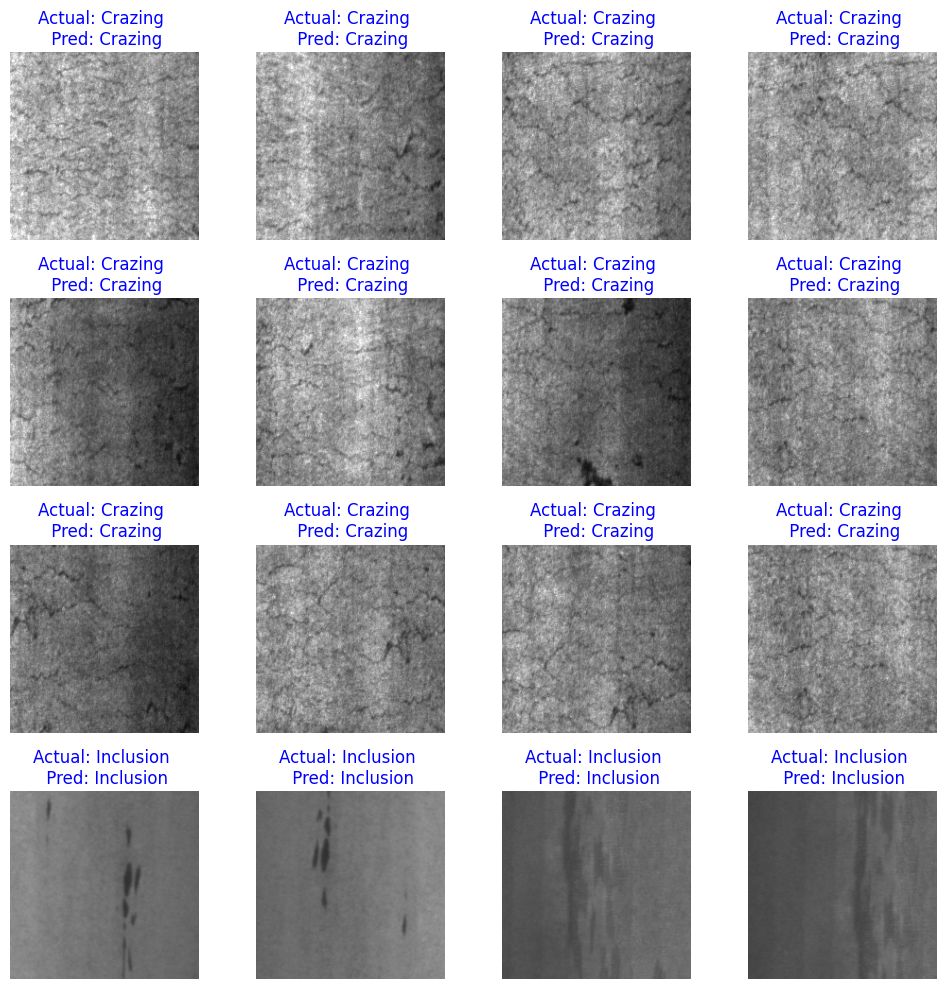

In [12]:
# visualize predictions
images, labels = test_iterator.next()

fig = plt.figure(figsize=(10, 10))
for index, image in enumerate(images):
    ax = fig.add_subplot(4, 4, index+1)
    plt.imshow(image)

    image = np.expand_dims(image, 0) # adding a batch dimension
    probs_pred = model.predict(image) # softmax probabilities for the 6 fault classes
    probs_pred = np.squeeze(probs_pred) # removing the batch dimension

    label_actual = np.argmax(labels[index])
    label_pred = np.argmax(probs_pred)

    if label_pred == label_actual:
        color='blue'
    else:
        color='red'

    ax.set_title(f'Actual: {class_names[label_actual]} \n Pred: {class_names[label_pred]}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()